In [1]:
# Import all the things..
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
import bambi as bm
%matplotlib inline

In [2]:
# Read in and preprocess the data
data = []

# Assumes all contents of https://osf.io/z6evq/ are in local Downloads folder
contents = open('/Users/tal/Downloads/osfstorage-archive/study 3/data/pnas_data.csv').readlines()

curr_tweet = []
tweets = []

# Tweet texts bleed across multiple lines, so fix this first
for l in contents[1:]:
    l = l.strip()
    if re.match('\d+,', l):
        curr_tweet = l
    else:
        curr_tweet += l.strip()
    if re.search(',(\d+)$', l):
        tweets.append(curr_tweet)

# Now extract data. Keep track of problematic lines we skip
skipped = 0
for t in tweets:
    m = re.match('(\d+),(.*?),(\w),(\d+)$', t)
    if m is None:
        skipped += 1
        continue
    data.append(m.groups())

# Verify we didn't skip too many
print(skipped)

11


In [3]:
# Load into a pandas DF
data = pd.DataFrame(data, columns=['RT', 'text', 'topic', 'id'])

In [4]:
# Let's see...
data.head()

,RT,text,topic,id
0,1388,"""Over 1,100,000 people killed by guns in the U...",g,1
1,762,"""Over 1,100,000 people killed by guns in the U...",g,2
2,748,"""If liberals won't punish an entire religion f...",g,3
3,436,"""""""@JenniferJJacobs: Trump: """"Protect the 2nd ...",g,4
4,342,Kurt Russell put gun control activists on blas...,g,5


In [5]:
# Load the word accuracies and create the feature whitelist
words = pd.read_csv('/Users/tal/Downloads/osfstorage-archive/study 3/data/combined_word_mean_acc.csv')
words.head()
whitelist = words['word'].tolist()

In [6]:
# Get word features
vec = CountVectorizer(vocabulary=whitelist)
features = vec.fit_transform(data['text'].values)

# Binarize matrix—we could also try with logged values
features[features > 1] = 1

# Add to DataFrame
feature_df = pd.DataFrame(features.toarray(), columns=whitelist)
all_data = pd.concat([data, feature_df], axis=1)

In [7]:
# Keep only rows with exactly 1 occurrence—this makes our
#  modeling life way easier, but note that ~10% of rows have
# more than one word.
trunc = all_data[features.sum(1) == 1]

In [8]:
# Multiply the feature matrix by the accuracy weights to get predicted accuracy
trunc['accuracy'] = trunc.iloc[:, 4:].values.dot(words[['all_acc_mean']].values)

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
# Melt to tidy format
final_data = pd.melt(trunc, ['id', 'RT', 'accuracy'], whitelist, 'word')
final_data = final_data.query('value == 1')

# Fix retweet dtype
final_data['RT'] = final_data['RT'].astype(int)

In [10]:
# First fit the ~same model as in the paper
model = bm.Model(final_data)

results_ffx = model.fit('RT ~ accuracy', chains=4, family='poisson')

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [accuracy, Intercept]
INFO:pymc3:NUTS: [accuracy, Intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:10<00:00, 85.44draws/s] 
The acceptance probability does not match the target. It is 0.8912659388390622, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846722827031827, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match t

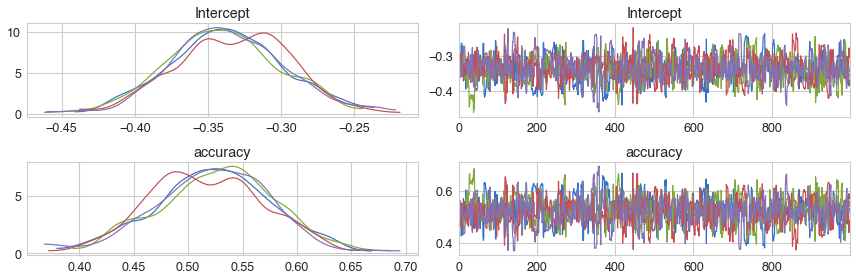

In [11]:
# Plot posteriors and chains
results_ffx.plot();

In [12]:
# Summarize the fixed effects--we get a huge effect
# of accuracy, as reported in the paper.
results_ffx.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,-0.336745,0.038017,-0.411501,-0.264875,903.164656,1.003345
accuracy,0.522129,0.053157,0.420248,0.625257,902.902619,1.003740


In [13]:
# Now with random effects...
mfx_model = bm.Model(final_data)

# Poisson regression of retweets on attentional capture,
# with words treated as random effects
results_mfx = model.fit('RT ~ accuracy', '1|word', chains=4, family='poisson')

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|word_offset, 1|word_sd, accuracy, Intercept]
INFO:pymc3:NUTS: [1|word_offset, 1|word_sd, accuracy, Intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [23:53<00:00,  1.08draws/s] 
The acceptance probability does not match the target. It is 0.7088126790465594, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6451086299578189, but should be close to 0.8. Try to increase the number of tunin

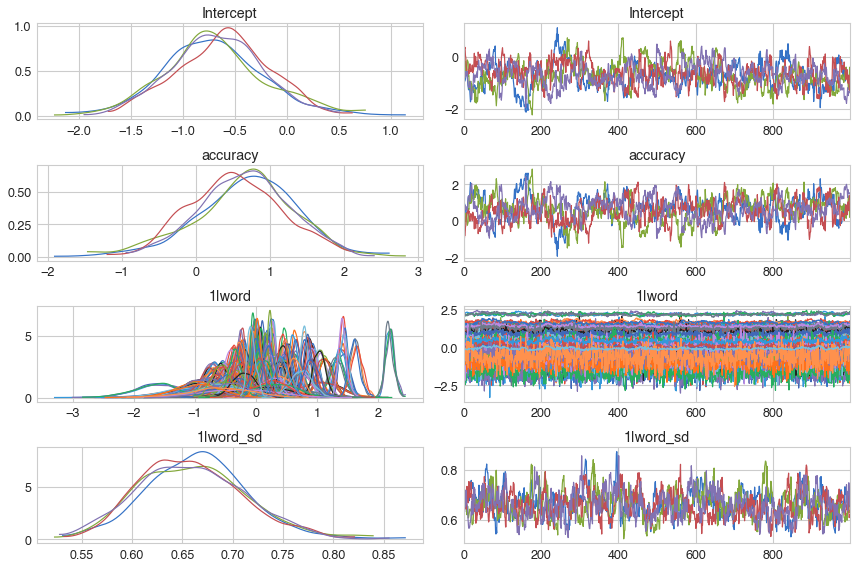

In [14]:
# Plot the mixed-effects results
results_mfx.plot();

In [15]:
# Summarize the fixed effects and variances--
# no effect of accuracy after accounting for between-word variance
results_mfx.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,-0.676963,0.460139,-1.563513,0.242041,163.621299,1.004956
accuracy,0.626741,0.640315,-0.673782,1.814462,161.798610,1.005881
1|word_sd,0.660345,0.052129,0.558835,0.760356,349.128845,1.001576


In [16]:
# Sort the random intercepts (i.e., words) by effect size
results_mfx.summary(ranefs=True).iloc[2:-1].sort_values('mean')

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|word[icon],-1.641352,0.362442,-2.342957,-0.937928,3156.074584,1.000851
1|word[alike],-1.008238,0.463244,-1.918520,-0.155283,3190.975278,1.000188
1|word[nasty],-0.975178,0.286057,-1.532905,-0.420885,1918.831691,1.002575
1|word[theft],-0.962289,0.368226,-1.700340,-0.259135,3627.505012,0.999740
1|word[sleep],-0.932469,0.271695,-1.507958,-0.431022,1299.813161,0.999834
1|word[goat],-0.913044,0.362365,-1.664568,-0.241562,3256.238291,1.000261
1|word[demon],-0.829206,0.438348,-1.672591,0.026613,3789.568647,1.000007
1|word[hike],-0.772235,0.267874,-1.319224,-0.272165,1929.295962,1.001843
1|word[liar],-0.747457,0.172578,-1.105679,-0.422510,465.189887,1.005057
1|word[dumb],-0.708470,0.139749,-1.002723,-0.449931,337.172866,1.007759


In [17]:
# There are only 117 estimates. Are there any words in the
# whitelist that don't occur at least once in the tweets?
set(whitelist) - set(final_data['word'].values)

{'lewd', 'maze', 'tile'}